<a href="https://colab.research.google.com/github/magenta/ddsp/blob/master/ddsp/colab/demos/timbre_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [0]:
# Copyright 2020 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP Timbre Transfer Demo

This notebook is a demo of timbre transfer using DDSP (Differentiable Digital Signal Processing). 
The model here is trained to generate audio conditioned on a time series of fundamental frequency and loudness. 

* [DDSP ICLR paper](https://openreview.net/forum?id=B1x1ma4tDr)
* [Audio Examples](http://goo.gl/magenta/ddsp-examples) 

By default, the notebook will download pre-trained models for Violin and Flute. You can train a model on your own sounds by using the [Train Autoencoder Colab](https://github.com/magenta/ddsp/blob/master/ddsp/colab/demos/train_autoencoder.ipynb).

<img src="https://storage.googleapis.com/ddsp/additive_diagram/ddsp_autoencoder.png" alt="DDSP Autoencoder figure" width="700">


# Environment Setup


This notebook extracts these features from input audio (either uploaded files, or recorded from the microphone) and resynthesizes with the model.

Have fun! And please feel free to hack this notebook to make your own creative interactions.

### Instructions for running:

* Make sure to use a GPU runtime, click:  __Runtime >> Change Runtime Type >> GPU__
* Press the ▶️button on the left of each of the cells
* View the code: Double-click any of the cells
* Hide the code: Double click the right side of the cell


In [1]:
#@title #Install and Import

#@markdown Install ddsp, define some helper functions, and download the model. This transfers a lot of data and _should take a minute or two_.


print('Installing from pip package...')


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import time

import crepe
import ddsp
import ddsp.training
from ddsp.colab.colab_utils import (download, play, record, specplot, upload,
                                    DEFAULT_SAMPLE_RATE)
import gin
from google.colab import files
import librosa
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Helper Functions
sample_rate = DEFAULT_SAMPLE_RATE  # 16000


print('Done!')

Installing from pip package...
Done!


bass_electronic_025-048-075.wav
(1, 64000)

Extracting audio features...
Audio features took 19.1 seconds
Restoring model took 1.5 seconds
Prediction took 1.4 seconds
bass_electronic_025-058-075.wav


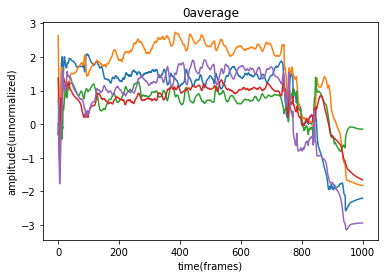

In [7]:
#@title Record or Upload Audio
#@markdown * Either record audio from microphone or upload audio from file (.mp3 or .wav) 
#@markdown * Audio should be monophonic (single instrument / voice)
#@markdown * Extracts fundmanetal frequency (f0) and loudness features. 
import librosa
import os
cnt = 0
audio_file_directory =  '/Users/raychen/Downloads/nsynth-test/audio/bass_electronic'
def find_model_dir(dir_name):
  # Iterate through directories until model directory is found
  for root, dirs, filenames in os.walk(dir_name):
    for filename in filenames:
      if filename.endswith(".gin") and not filename.startswith("."):
        model_dir = root
        break
  return model_dir 
def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, f0_octave_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (f0_octave_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
                                    0.0, 
                                    librosa.midi_to_hz(110.0))
  return audio_features


def mask_by_confidence(audio_features, confidence_level=0.1):
  """For the violin model, the masking causes fast dips in loudness. 
  This quick transient is interpreted by the model as the "plunk" sound.
  """
  mask_idx = audio_features['f0_confidence'] < confidence_level
  audio_features['f0_hz'][mask_idx] = 0.0
  # audio_features['loudness_db'][mask_idx] = -ddsp.spectral_ops.LD_RANGE
  return audio_features


def smooth_loudness(audio_features, filter_size=3):
  """Smooth loudness with a box filter."""
  smoothing_filter = np.ones([filter_size]) / float(filter_size)
  audio_features['loudness_db'] = np.convolve(audio_features['loudness_db'], 
                                           smoothing_filter, 
                                           mode='same')
  return audio_features

accu_harmonics = np.zeros((1000,5))
for filename in os.listdir(audio_file_directory):
    print(filename) 
    cnt = cnt+1
    if cnt >1:
        break
    audio,sr = librosa.load(os.path.join(audio_file_directory,filename), sr=sample_rate)
    audio = audio[np.newaxis, :]
    print(audio.shape)
    print('\nExtracting audio features...')


    ddsp.spectral_ops.reset_crepe()


    start_time = time.time()
    audio_features = ddsp.training.eval_util.compute_audio_features(audio)
    audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
    audio_features_mod = None
    print('Audio features took %.1f seconds' % (time.time() - start_time))

    model = 'Violin' #@param ['Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone','Upload your own (checkpoint folder as .zip)']
    MODEL = model


    gin_file = os.path.join('.', 'operative_config-0.gin')

    with gin.unlock_config():
        gin.parse_config_file(gin_file, skip_unknown=True)
 

    ckpt_files = [f for f in tf.io.gfile.listdir('.') if 'ckpt' in f]
    ckpt_name = ckpt_files[0].split('.')[0]
    ckpt = os.path.join('.', ckpt_name)


    time_steps_train = gin.query_parameter('DefaultPreprocessor.time_steps')
    n_samples_train = gin.query_parameter('Additive.n_samples')
    hop_size = int(n_samples_train / time_steps_train)

    time_steps = int(audio.shape[1] / hop_size)
    n_samples = time_steps * hop_size


    gin_params = [
        'Additive.n_samples = {}'.format(n_samples),
        'FilteredNoise.n_samples = {}'.format(n_samples),
        'DefaultPreprocessor.time_steps = {}'.format(time_steps),
    ]

    with gin.unlock_config():
        gin.parse_config(gin_params)



    for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
        audio_features[key] = audio_features[key][:time_steps]
        audio_features['audio'] = audio_features['audio'][:, :n_samples]



    model = ddsp.training.models.Autoencoder()
    model.restore(ckpt)


    start_time = time.time()
    _ = model(audio_features, training=False)
    print('Restoring model took %.1f seconds' % (time.time() - start_time))
    auto_adjust = True #@param{type:"boolean"}


    f0_octave_shift =  0 #@param {type:"slider", min:-2, max:2, step:1}
    f0_confidence_threshold =  0 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
    loudness_db_shift = 0 #@param {type:"slider", min:-20, max:20, step:1}



    audio_features_mod = {k: v.copy() for k, v in audio_features.items()}
    if MODEL in ['Violin', 'Flute', 'Flute2', 'Trumpet', 'Saxophone', 'Tenor_Saxophone']:
    # Adjust the peak loudness.
        l = audio_features['loudness_db']
        model_ld_avg_max = {
           'Violin': -34.0,
           'Flute': -45.0,
           'Flute2': -44.0,
           'Trumpet': -52.3,
           'Tenor_Saxophone': -31.2
           }[MODEL]
        ld_max = np.max(audio_features['loudness_db'])
        ld_diff_max = model_ld_avg_max - ld_max
        audio_features_mod = shift_ld(audio_features_mod, ld_diff_max)

        # Further adjust the average loudness above a threshold.
        l = audio_features_mod['loudness_db']
        model_ld_mean = {
            'Violin': -44.0,
            'Flute': -51.0,
            'Flute2': -53.0,
            'Trumpet': -69.2,
            'Tenor_Saxophone': -50.8
        }[MODEL]
        ld_thresh = -70.0
        ld_mean = np.mean(l[l > ld_thresh])
        ld_diff_mean = model_ld_mean - ld_mean
        audio_features_mod = shift_ld(audio_features_mod, ld_diff_mean)

    
        model_p_mean = {
           'Violin': 73.0,
           'Flute': 81.0,
           'Flute2': 74.0,
           'Trumpet': 65.8,
           'Tenor_Saxophone': 57.8
        }[MODEL]
        p = librosa.hz_to_midi(audio_features['f0_hz'])
        p[p == -np.inf] = 0.0
        p_mean = p[l > ld_thresh].mean()
        p_diff = model_p_mean - p_mean
        p_diff_octave = p_diff / 12.0
        round_fn = np.floor if p_diff_octave > 1.5 else np.ceil
        p_diff_octave = round_fn(p_diff_octave)
        audio_features_mod = shift_f0(audio_features_mod, p_diff_octave)

    else:
        print('\nUser uploaded model: disabling auto-adjust.')

  
    audio_features_mod = shift_ld(audio_features_mod, loudness_db_shift)
    audio_features_mod = shift_f0(audio_features_mod, f0_octave_shift)
    audio_features_mod = mask_by_confidence(audio_features_mod, f0_confidence_threshold)
    
    af = audio_features if audio_features_mod is None else audio_features_mod

    #af = audio_features
    start_time = time.time()
    audio_gen = model(af, training=False)
    print('Prediction took %.1f seconds' % (time.time() - start_time))
    control_dict = model.get_controls(af)
    top_harmonics = control_dict['harmonic_distribution'][0, :, 0:5]
    accu_harmonics = accu_harmonics+top_harmonics[0:1000,:]
    plt.clf()
    plt.plot(top_harmonics)
    plt.xlabel('time(frames)')
    plt.ylabel('amplitude(unnormalized)')
    plt.title(filename.strip('.wav'))
    plt.savefig(os.path.join(audio_file_directory,filename.strip('.wav')))
accu_harmonics = accu_harmonics/(cnt-1)
plt.clf()
plt.plot(top_harmonics)
plt.xlabel('time(frames)')
plt.ylabel('amplitude(unnormalized)')
plt.title('0average')
plt.savefig(os.path.join(audio_file_directory,'0average'))



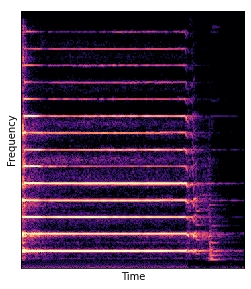

In [10]:

audio_gen = model(af, training=False)
specplot(audio_gen)
play(audio_gen)

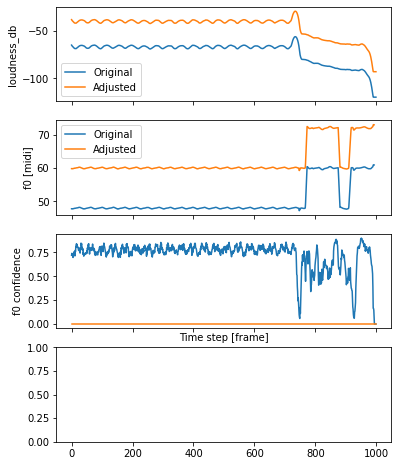

Prediction took 1.6 seconds
(60,)
[0 2 1]
[ 0  2  1 58 55]
audio
(1, 64000)
loudness_db
(1, 1000, 1)
f0_hz
(1, 1000, 1)
f0_confidence
(1000,)
f0_scaled
(1, 1000, 1)
ld_scaled
(1, 1000, 1)
amps
(1, 1000, 1)
harmonic_distribution
(1, 1000, 60)
noise_magnitudes
(1, 1000, 65)
additive
	controls
		amplitudes
(1, 1000, 1)
		harmonic_distribution
(1, 1000, 60)
		f0_hz
(1, 1000, 1)
	signal
(1, 64000)
filtered_noise
	controls
		magnitudes
(1, 1000, 65)
	signal
(1, 64000)
add
	controls
		signal_one
(1, 64000)
		signal_two
(1, 64000)
	signal
(1, 64000)
reverb
	controls
		audio
(1, 64000)
		ir
(1, 48000)
	signal
(1, 64000)
processor_group
	signal
(1, 64000)


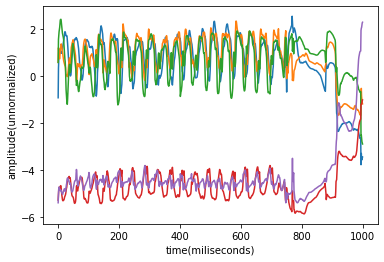

In [69]:
#@title #Resynthesize Audio

af = audio_features if audio_features_mod is None else audio_features_mod

# Run a batch of predictions.
start_time = time.time()
audio_gen = model(af, training=False)
print('Prediction took %.1f seconds' % (time.time() - start_time))
control_dict = model.get_controls(af)
harmonic_sum = np.sum(control_dict['harmonic_distribution'][0,:,:],axis = 0)
print(harmonic_sum.shape)
ind_max = np.argpartition(harmonic_sum, -3)[-3:]
print(ind_max)
ind_min = np.argpartition(harmonic_sum, 2)[:2]
indices = np.concatenate((ind_max,ind_min))
print(indices)



'''
for k,v in control_dict.items():
    print(k)
    if isinstance(v,dict)==0:
       print(v.shape)
    else:
        for k2,v2 in v.items():
            print('\t'+k2)
            if isinstance(v2,dict):  
               for k3,v3 in v2.items():
                  print('\t\t'+k3)
                  print(v3.shape)
            else:
                print(v2.shape)

# Plot
print('Original')
#play(audio)

print('Resynthesis')
#play(audio_gen)

specplot(audio)
plt.title("Original")

specplot(audio_gen)
_ = plt.title("Resynthesis")
'''
#fig, ax = plt.subplots(nrows=1, 
#                       ncols=1, 
#                       sharex=True,
#                       figsize=(6, 8))
#ax[0].plot(control_dict['loudness_db'][0])
#ax[0].set_ylabel('loudness_db')


#ax[1].plot(librosa.hz_to_midi(control_dict['f0_hz'][0]))
#ax[1].set_ylabel('f0 [midi]')


#harm1 = control_dict['harmonic_distribution'][0, :, indices[0]]
#harm2 = control_dict['harmonic_distribution'][0, :, indices[1]]
#harm3 = control_dict['harmonic_distribution'][0, :, indices[2]]
#harm4 = control_dict['harmonic_distribution'][0, :, indices[3]]
#harm5 = control_dict['harmonic_distribution'][0, :, indices[4]]
#harm = np.stack((harm1,harm2,harm3,harm4,harm5),axis = 1)
plt.plot(control_dict['harmonic_distribution'][0, :, 0:5])
plt.xlabel('time(miliseconds)')


_ = plt.ylabel('amplitude(unnormalized)')
